# Identifying Yoga Poses

We've collected a few samples for each pose we'd like to categorize, and we need to learn how to identify which pose the user is in. We first used our tflite convolutional pose machine model to obtain a graphical representation of the poses we collected. This will produce a 28 point array of the various body part coordinates in each sample. We'll save this array along with its correct pose label to construct a dataset. First, let's import all the libraries we'll be using.

In [3]:
%matplotlib inline

import pickle
import multiprocessing
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

Let's load our data and take a peak at what those samples look like.

In [29]:
dataset = pd.read_csv('./data/data_train_3mdad_keypoints.csv', index_col=0)
dataset.head()

,1
0,
"32, 56, 52, 60, 52, 48, 64, 44, 68, 48, 56, 76, 68, 44, 64, 52, 88, 36, 64, 44, 84, 24, 92, 76, 68, 56, 92, 60",AC08
"20, 64, 40, 72, 40, 60, 60, 64, 56, 48, 48, 88, 68, 76, 56, 48, 80, 56, 52, 40, 72, 32, 84, 64, 76, 32, 76, 28",AC08
"28, 52, 48, 60, 52, 48, 52, 40, 48, 32, 56, 72, 68, 80, 56, 56, 88, 48, 56, 32, 76, 24, 88, 56, 72, 84, 80, 20",AC08
"20, 64, 40, 68, 44, 52, 60, 52, 52, 60, 56, 88, 48, 76, 92, 88, 84, 56, 52, 24, 76, 24, 88, 88, 76, 28, 80, 28",AC08
"28, 60, 44, 64, 48, 52, 60, 48, 56, 44, 40, 80, 60, 48, 52, 40, 76, 68, 48, 36, 84, 52, 76, 76, 60, 56, 76, 44",AC08


In [30]:
dataset.columns = ['keypts', 'label']
dataset = pd.concat([dataset['keypts'].str.split(',', expand=True), dataset['label']], axis=1)

In [31]:
dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,label
0,32,56,52,60,52,48,64,44,68,48,...,44,84,24,92,76,68,56,92,60,AC08
1,20,64,40,72,40,60,60,64,56,48,...,40,72,32,84,64,76,32,76,28,AC08
2,28,52,48,60,52,48,52,40,48,32,...,32,76,24,88,56,72,84,80,20,AC08
3,20,64,40,68,44,52,60,52,52,60,...,24,76,24,88,88,76,28,80,28,AC08
4,28,60,44,64,48,52,60,48,56,44,...,36,84,52,76,76,60,56,76,44,AC08


Format the data so we can feed it to a model.

In [32]:
# Spliting the points and the labels
X = dataset.iloc[:, :-1].values  
y = dataset.iloc[:, 28].values

# And split the data into appropriate data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20) 

In [33]:
X

array([['32', ' 56', ' 52', ..., ' 56', ' 92', ' 60'],
       ['20', ' 64', ' 40', ..., ' 32', ' 76', ' 28'],
       ['28', ' 52', ' 48', ..., ' 84', ' 80', ' 20'],
       ...,
       ['8', ' 44', ' 12', ..., ' 48', ' 80', ' 24'],
       ['16', ' 68', ' 40', ..., ' 76', ' 76', ' 28'],
       ['16', ' 64', ' 36', ..., ' 68', ' 76', ' 28']], dtype=object)

In [34]:
class_names = list(set(y))
num_class = len(class_names)
cores = multiprocessing.cpu_count()

Our data is ready to feed it to a model! Our first approach will be to classify which pose the user is currently in. If the user is not in the correct pose, we'll give them some advice on how to execute it. As we progress, we'll want to think about how to evaluate the user's pose, ie. how well are they execuring the pose. But for now, let's just determine if a user is in the right pose.

We'll try XGBoost. This algorithm is an implementation of gradient boosted decision trees. It ensembles many decision trees into one model - making it more accurate as a collection of trees.

XGBoost is very fast and it has more parameters to tune to improve the model. Feel free to pay with the learning_rate, n_estimators, etc to get better results. Also keep in mind that more data never hurts.

In [35]:
clf = XGBClassifier(max_depth=6, 
                    learning_rate=0.01, 
                    n_estimators=500, 
                    objective='multi:softmax', 
                    n_jobs=cores, 
                    num_class=num_class)

In [36]:
clf.fit(X_train, y_train)
preds = clf.predict(X_test)

We can see how well the model is grouping samples by printing the confusion matrix of the model. The confusion matrix will show us how often the model gets confused about a sample and misclassifies it AND to what it misclassifies.

We'll also look at the classification report which will give us the recall and precision among other stats for each label

In [37]:
from sklearn.metrics import confusion_matrix, classification_report
conf_matrix = confusion_matrix(y_test, preds)
print(conf_matrix)

class_report = classification_report(y_test, preds)
print(class_report)

[[660  29  36  15  30  45  26  36  26  43  28  17   4  26   6  20]
 [ 75 284  51  69  56  37  95  64  30  47  35  28  26  45  37  40]
 [ 27  16 743   8  51  12  39  21  21  37  23  14  16  10   8  31]
 [140  57  33 504  45  80  72  75  40  47  31  14  27  30  27  27]
 [ 22  23  45   3 681  13  29  24  20  22  12   8  12  21   6  25]
 [ 95  35  45  27  32 479  23 115  18  36  11  10  11  28  10  27]
 [  6  27  20  24  31   2 847  11  29  37  17  10  44  15  16  47]
 [ 60  22  26  22  28  42  28 783  23  26  14  22   8  50   6  26]
 [ 35  70  66  43 115  22 113  68 341  71  23  29  40  36  28  59]
 [ 89  30  61  20  63  45  74  53  39 573  39  15  34  42  42  54]
 [ 92  49  87  53  73  16 136  81  39  91 248  32  29  28  34  66]
 [ 76  44  49  29  49  49 139 106  34  37  32 253  40  35  20  61]
 [ 13  44  31  47  98  19 176  28  22  36  28  15 304  20  29  80]
 [ 63  23  39  19  40  69  25 139  19  51  24  14  12 447   8  17]
 [ 17  52  50  34  52  13  58  42  31  60  37   7  15   9 398 

And to get a better view let's graph the confusion matrix.

In [38]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, rotation=45)
    plt.yticks(tick_marks)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

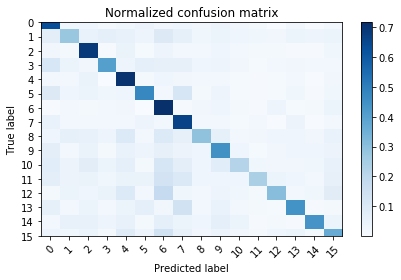

Classes:  ['AC01', 'AC02', 'AC03', 'AC04', 'AC05', 'AC06', 'AC07', 'AC08', 'AC09', 'AC10', 'AC11', 'AC12', 'AC13', 'AC14', 'AC15', 'AC16']


In [39]:
plot_confusion_matrix(conf_matrix, classes=sorted(class_names), normalize=True,
                      title='Normalized confusion matrix')
plt.show()
print('Classes: ', sorted(class_names))

Dark blue on the diagonal is what we're aiming for. We can see the model is really good at predicting tree_pose but warrior_1 gets confused with crescent_lunge and warrior_3 poses. However, this is a great start classifying a handful of distinct poses. We want to save the model to file so we can run inference while our virtual instructor is running.

In [40]:
filename = './models/xgb_3mdad_poses.sav'
pickle.dump(clf, open(filename, 'wb'))